In [1]:
from IPython.core.display import HTML, Markdown, display

import numpy as np
import numpy.random as npr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import pingouin as pg
import math

import ipywidgets as widgets

import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import numpy as np
import pandas as pd
from datetime import datetime
from ipycanvas import Canvas, hold_canvas

from sdt_exp import *

# Enable plots inside the Jupyter Notebook
%matplotlib inline

# Signal detection: Part 2

Authored by *Todd Gureckis*.

In the previous lab you learned some of the basic analysis steps involved in signal detection analysis.  In particular, we learned how to compute a statistic we called d' (dprime) and c (bias/criterion).  These variables are commonly used in studies of perception to understand the performance of a subject on a task independent of their response bias (here meaning tendency to give a particular response).  

In the second part of the lab we will analyze data from a simple detection experiment you will have just conducted on yourselves.  You will get to put your python knowledge into practice by reading in the data analyzing it. 

## The Experiment Instructions

In this experiment you job will be similar to that of a doctor.  There are going to be small "clusters" of points which we might think of as a tumor or some other biological measurement.  You can use the interaction element below to examine a few of these "clusters".

Try using the widget below to slide between a lot of dots within a cluster and a small number.  Sweep back and forth and get an idea of what a "cluster" could look like.  The dots are spread out to a certain degree as you can see more clearly with the large number of dots. 

In [2]:
@widgets.interact(dots=(1, 75, 5))
def draw(dots):
    return draw_stimulus(include_source=True,
                         n_background_dots=0,
                         n_source_dots=dots,
                         source_sd=10,
                         source_border=20,
                         width=400,
                         height=400)

interactive(children=(IntSlider(value=36, description='dots', max=75, min=1, step=5), Output()), _dom_classes=…

The challenge is that these dots are going to be hidden in a background of "noise" which is other dots unrelated to the cluster.  Here is an example of the background with no cluster present:

In [3]:
draw_stimulus(include_source=False,
              n_background_dots=30 * 30,
              n_source_dots=0,
              source_sd=10,
              source_border=20,
              width=400,
              height=400)

Canvas(height=425, layout=Layout(grid_area='canvas'), width=425)

You can run the above cell many times to see different example patterns when the cluster is absent.

Next here is an example of a very large cluster hidden in the background noise:

In [4]:
draw_stimulus(include_source=True,
              n_background_dots=30 * 30,
              n_source_dots=60,
              source_sd=10,
              source_border=20,
              width=400,
              height=400)

Canvas(height=425, layout=Layout(grid_area='canvas'), width=425)

From this example you can see a very clear "cluster" or tumor in the stimulus.  Here is one where there is a cluster/tumor but it is a little less obvious:

In [5]:
draw_stimulus(include_source=True,
              n_background_dots=30 * 30,
              n_source_dots=50,
              source_sd=10,
              source_border=20,
              width=400,
              height=400)

Canvas(height=425, layout=Layout(grid_area='canvas'), width=425)

Finally, here is one where it is pretty hard to tell that there is a cluster at all (oh but there is one involving only 20 dots!):

In [6]:
draw_stimulus(include_source=True,
              n_background_dots=30 * 30,
              n_source_dots=20,
              source_sd=10,
              source_border=20,
              width=400,
              height=400)

Canvas(height=425, layout=Layout(grid_area='canvas'), width=425)

Your job in the experiment will be to view stimuli such as the ones above and judge if you think there is a cluster/tumor present in the image.  It can often be hard to tell because even in the random dots there can be little clusters of dots that group together.  Just try to do your best.  Notice that there is a red "absent" button and a green "present" button.  You should press "absent" if you think the cluster/tumor is not there, and press "present" if you think it is there.

Before running the next cell set the subject number to your NYU netid (I will anonymize this later but will let me check that everyone has done the experiment).

## Run the Experiment!

In [7]:
subject_number = 'pj787'  # set your subject number here
exp = Detection_Experiment(subject_number)
exp.start_experiment()

The experiment is finished!
Data saved to .csv
Also available as exp.trials
-------------
Thanks so much for your time!


## Getting the data

After you run the experiment, the data will be output to a .csv file tied to your subject number.  Also it is available as as pandas data frame in the current kernel environment as `exp.trials`:

In [ ]:
exp.trials.head()

## Experiment design

In the experiment, you saw a number of trials where field of random colored and positioned dots appear.  On some trials a small "cluster" of points was added to the stimulus.  The number of dots in the cluster was manipulated across conditions so that it was more or less obvious that there was a cluster.  In some cases the number of dots within the cluster was so small that it was hard to detect it, but other cases it might have been more visually obvious.  This is very similar to the type of visual diagnosis that a doctor or airport screener might perform (deciding of a tumor or a gun is present in an image). Your task was to indicate if it was a "stimulus/cluster present" trial or a "stimulus/cluster absent" trial.  The computer recorded your response and your reaction time.

An overview of the situation is shown here:

### The things we manipulated!

There were actually four different types of clusters shown on any given "stimulus present" trial. One was a **small** stimulus made up of 10 dots, one was a medium made up of 15 dots, one type of made up of 25, and finally one was  made up of 60 dots:

<center>
<img src="images/dots.png" width="900">
</center>

As the number of dots increases the general visibility of the cluster becomes more clear and easier to detect.

In total there were 100 stimulus absent trials and 25 of each of the four types of stimulus present trials.  The purpose of this was so that a perfect subject with robot-quality vision would say "yes" half the time in the experiment so there is no overall bias toward one response.

In this lab we are interested in analyzing the effect of strength of the stimulus cluster (i.e., number of dots) on the two signal detection variables we learned about in the previous lecture and lab.

## Analysis Steps


Remember from the previous lab that our model for signal detection looks something like this:
<img src="http://gru.stanford.edu/lib/exe/fetch.php/tutorials/nobias.png?w=&h=&cache=cache">

and we showed how we can compute $d'$ and $c$ by computing only the number of false alarms and hits and subjecting those to a particular mathematical transformation.  In this case we actually have four stimulus conditions (10, 15, 25, or 60).  So our goal will be to compute the hits and false alarms **separately** for the two different types of stimuli.  This will mean that each person in our experiment will be described by eight numbers:

- A d' (d-prime) under (10, 15, 25, 60) visibility cluster conditions
- A c under (10, 15, 25, 60) visibility cluster conditions

Once we have this we want to perform a simple hypothesis test.  Is performance, measured by d' higher in the high visibility conditions?  We have strong reason to suspect this is the case but it'll be a nice check of our understanding if we can related the abstract calculation we performed in the previous lab to answer this simple quesiton.

Answering this question will push our skills at using pandas to organize our data, and using pingouin to compute a t-test.

<div class="alert alert-info" role="alert">
  <strong>Question 1</strong> <br>
    If we compute one $d'$ for each participant for each stimulus conditon and want to compare performance in the two conditions, what type of t-test should we most likely use?
</div>

The paired t-test.

<div class="alert alert-info" role="alert">
  <strong>Question 2</strong> <br>
    To begin we want to read in the data from each participant into a pandas data frame using `pd.read_csv()` and the used `pd.concat()` to combine them.   After you read in the data, inspect the columns and check the data for any inconsistencies that might affect our analysis (e.g., subjects who didn't perform any trials, etc...).
</div>

In [2]:
import os

As a reminder the following show a simple for loop (called a list comprehension) that lets you get the filenames for the lab data set.  You can use this to find the file names that you need to read in with `pd.read_csv()`.  If you need a reminder refer back to your mental rotation lab which should be on your Jupyterhub node still!

In [3]:
# this is an example list comprehension which reads in the all the files.
# the f.startswith() part just gets rid of any junk files in that folder
filenames = [
    'sdt1-data/' + f for f in os.listdir('sdt1-data') if not f.startswith('.')
]
filenames

['sdt1-data/sdt-tg35.csv',
 'sdt1-data/sdt-fwm229.csv',
 'sdt1-data/sdt-kyy230.csv',
 'sdt1-data/sdt-srd389.csv',
 'sdt1-data/sdt-jwk438.csv',
 'sdt1-data/sdt-toa220.csv',
 'sdt1-data/sdt-mae475.csv',
 'sdt1-data/sdt-wx556.csv',
 'sdt1-data/sdt-qc540.csv',
 'sdt1-data/sdt-jc8639.csv',
 'sdt1-data/sdt-pj787.csv',
 'sdt1-data/sdt-ab8200.csv',
 'sdt1-data/sdt-aed454.csv',
 'sdt1-data/sdt-so1304.csv',
 'sdt1-data/sdt-aed457.csv',
 'sdt1-data/sdt-djb596.csv',
 'sdt1-data/sdt-ipv205.csv',
 'sdt1-data/sdt-peo225.csv',
 'sdt1-data/sdt-jj2401.csv',
 'sdt1-data/sdt-iff207.csv']

In [4]:
dfs = []
for f in filenames:
    dfs.append(pd.read_csv(f))

data = pd.concat(dfs, ignore_index=True)
data.drop(data.columns[0], axis=1, inplace=True)
data.dropna()
print(data.shape[0])
data.head()

3840


,signal_present,signal_type,trial_num,button_position,subject_number,responses,rt,correct_resp
0,1,60,0,left,tg35,0,3252.472,0
1,1,10,1,left,tg35,1,1504.471,1
2,1,10,2,left,tg35,1,1864.182,1
3,1,15,3,left,tg35,0,37.681,0
4,0,0,4,left,tg35,1,168.091,0


<div class="alert alert-success" role="alert">
  <strong>Stop and share</strong> <br>
  Did you find any interesting or important points about the data that you want to share with the class?  Let's get everyone on the same page so we get similar results so if you find something important (good or bad) please take a moment and share!
</div>

<div class="alert alert-info" role="alert">
  <strong>Question 3</strong> <br>
    Now that we have the analysis dataframe let's perform our planned analysis on a single subject.  Create a new dataframe, subselecting from the main frame with the data from a single subject.
</div>

In [5]:
df = data[data['subject_number'] == 'tg35']
df

,signal_present,signal_type,trial_num,button_position,subject_number,responses,rt,correct_resp
0,1,60,0,left,tg35,0,3252.472,0
1,1,10,1,left,tg35,1,1504.471,1
2,1,10,2,left,tg35,1,1864.182,1
3,1,15,3,left,tg35,0,37.681,0
4,0,0,4,left,tg35,1,168.091,0
...,...,...,...,...,...,...,...,...
195,1,15,195,left,tg35,0,2063.387,0
196,0,0,196,left,tg35,0,1575.104,1
197,1,60,197,left,tg35,1,4390.985,1
198,1,15,198,left,tg35,0,5022.832,0


<div class="alert alert-info" role="alert">
  <strong>Question 4</strong> <br>
    Referring back to the first notebook from the lab compute the hits and false alarms for this subject for each stimulus present condition.  One note about the false alarms: remember that false alarms are trials where the stimulus was absent but the subject said it was present.  There is only one type of these trials in the experiment.  So when you compute the statistics you really will create five numbers of this participant.  The hits for each of the stimulus present conditions, and an overall false alarm rate.  What are these numbers for this subject?  Remember also that if you take the `mean()` of a column of 0/1 values it will tell you the proportion of those trials which are 1.
</div>

In [6]:
hit_10 = df[df.signal_type == 10].responses[df.signal_present == 1].mean()
hit_15 = df[df.signal_type == 15].responses[df.signal_present == 1].mean()
hit_25 = df[df.signal_type == 25].responses[df.signal_present == 1].mean()
hit_60 = df[df.signal_type == 60].responses[df.signal_present == 1].mean()
fa = df.responses[df.signal_present == 0].mean()
print(
    'Hit rate: Stimulus 10 - {:.2f}, Stimulus 15 - {:.2f}, Stimulus 25 - {:.2f}, Stimulus 60 - {:.2f}'
    .format(hit_10, hit_15, hit_25, hit_60))
print('Flase alarm rate: {:.2f}'.format(fa))

Hit rate: Stimulus 10 - 0.08, Stimulus 15 - 0.12, Stimulus 25 - 0.44, Stimulus 60 - 0.92
Flase alarm rate: 0.03


<div class="alert alert-info" role="alert">
  <strong>Question 5</strong> <br>
    Ok now compute the d' and c values for this subject.  Refer back to the previous notebook for reference if you need the equations and python code.  What can you tell from looking at your computed values?  If for some reason you can't compute these values in your experiment (e.g., if the subject has no hits or no false alarms) then try question 4 again with a different subject.
</div>

In [27]:
d_primes = [
    stats.norm.ppf(hit) - stats.norm.ppf(fa)
    for hit in [hit_10, hit_15, hit_25, hit_60]
]
d_primes

[0.4757220478416182,
 0.7058068160851607,
 1.7298243926544739,
 3.2858651684608837]

In [11]:
c = [
    -(stats.norm.ppf(hit) + stats.norm.ppf(fa)) / 2.0
    for hit in [hit_10, hit_15, hit_25, hit_60]
]
c

[1.6429325842304419,
 1.5278902001086707,
 1.0158814118240143,
 0.2378610239208091]

We can tell that when signal is easier to detect, i.e. hit rate increases, the $d'$ increases and $c$ decreases.

<div class="alert alert-info" role="alert">
  <strong>Question 6</strong> <br>
    Ok, so now you have performed the desired analysis for one subject.  You have computed eight numbers for that subject described above.  Now we want to repeat this for each subject. There are two ways to do this.  One is using the pandas groupby() function.  This is somewhat of the advanced mode version but if you do this you can probably perform the analysis in only 5-6 lines of code.  An alternative approach is to generalize the code you just wrote to use a for loop that iterates over each subject in the data frame.  Which ever way you choose you might find it helpful to refer to the <a href="http://gureckislab.org/courses/fall19/labincp/tips/fortyforloops.html">Forty For Loops</a> notebook I provided which shows some example templates for using for loops to analyze individual subject data in pandas dataframes.  The end result is that you want a dataframe containing the d' and c for each subject for each stimulus condition.
</div>

In [12]:
d_groupby = data.groupby('subject_number')
stimulus_types = [10, 15, 25, 60]

In [13]:
%%capture --no-display

results = pd.DataFrame()

results['false_alarm'] = d_groupby.apply(
    lambda x: x.responses[x.signal_present == 0].mean())
for i in stimulus_types:
    results[str(i) + '_hit'] = d_groupby.apply(lambda x: x[
        x.signal_type == i].responses[x.signal_present == 1].mean())
    results[str(i) + '_d\''] = stats.norm.ppf(
        results[str(i) + '_hit']) - stats.norm.ppf(results['false_alarm'])
    results[str(i) + '_c'] = -(stats.norm.ppf(results[str(i) + '_hit']) +
                               stats.norm.ppf(results['false_alarm'])) / 2.0
results_prv = results
results

,false_alarm,10_hit,10_d',10_c,15_hit,15_d',15_c,25_hit,25_d',25_c,60_hit,60_d',60_c
subject_number,,,,,,,,,,,,,
XXX,0.15,0.00,-inf,inf,0.00,-inf,inf,0.75,1.710923,0.180972,NaN,NaN,NaN
ab8200,0.19,0.16,-0.116562,0.936177,0.56,1.028866,0.363464,0.92,2.282968,-0.263588,1.000,inf,-inf
aed454,0.13,0.24,0.420089,0.916347,0.56,1.277360,0.487711,1.00,inf,-inf,0.960,2.877077,-0.312147
aed457,0.72,0.64,-0.224383,-0.470650,0.84,0.411616,-0.788650,0.80,0.258780,-0.712231,1.000,inf,-inf
djb596,0.18,0.28,0.332524,0.749103,0.36,0.556906,0.636912,0.88,2.090352,-0.129811,0.960,2.666051,-0.417660
fwm229,0.08,0.16,0.410614,1.199765,0.56,1.556041,0.627051,0.96,3.155758,-0.172807,1.000,inf,-inf
ipv205,0.13,0.08,-0.278680,1.265731,0.40,0.873044,0.689869,0.80,1.968012,0.142385,1.000,inf,-inf
jc8639,0.28,0.20,-0.258780,0.712231,0.48,0.532688,0.316498,0.96,2.333528,-0.583922,0.960,2.333528,-0.583922
jj2401,0.08,0.12,0.230085,1.290029,0.08,0.000000,1.405072,0.04,-0.345615,1.577879,0.400,1.151724,0.829209


In [14]:
results.replace([np.inf, -np.inf], np.nan, inplace=True)
results = results.filter(regex=("(_d)|(_c)")).dropna()
results

,10_d',10_c,15_d',15_c,25_d',25_c,60_d',60_c
subject_number,,,,,,,,
djb596,0.332524,0.749103,0.556906,0.636912,2.090352,-0.129811,2.666051,-0.417660
jc8639,-0.258780,0.712231,0.532688,0.316498,2.333528,-0.583922,2.333528,-0.583922
jj2401,0.230085,1.290029,0.000000,1.405072,-0.345615,1.577879,1.151724,0.829209
kyy230,0.575699,1.462836,1.167845,1.166764,2.004033,0.748669,2.925673,0.287850
peo225,0.150587,0.025140,0.568133,-0.183633,0.568133,-0.183633,1.505505,-0.652319
so1304,-0.050924,-0.176431,0.051454,-0.227620,-0.352863,-0.025462,0.116746,-0.260266
tg35,0.475722,1.642933,0.705807,1.527890,1.729824,1.015881,3.285865,0.237861
toa220,0.239782,1.524963,0.938551,1.175578,2.486475,0.401616,3.049925,0.119891
wx556,-0.125423,-0.012558,-0.328617,0.089039,-0.226239,0.037850,-0.025116,-0.062712


<div class="alert alert-info" role="alert">
  <strong>Question 7</strong> <br>
    Now that you have your summary statistics computed, our next step is to ask if the conditions are different on either the d' or c measure.  For now concentrate on the easiest and hardest conditions to see if there is a effect in the most dissimilar conditions.  Then compare the hardest and second hardest conditions. Conduct the appropriate t-test to tell if these conditions are different.  The chapter reading from this week has all the code you need.  However you might find it helpful to refer to the pingouin documentation for the <a href="https://pingouin-stats.org/generated/pingouin.ttest.html#pingouin.ttest">t-test function</a>.
</div>

In [15]:
pg.ttest(x=results['10_d\''], y=results['60_d\''], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-4.670626,8,two-sided,0.001601,"[-2.56, -0.87]",1.882893,27.931,0.998302


In [16]:
pg.ttest(x=results['15_d\''], y=results['25_d\''], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.364851,8,two-sided,0.045612,"[-1.34, -0.02]",0.732348,1.956,0.488951


In [23]:
pg.ttest(x=results['10_c'], y=results['60_c'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,4.670626,8,two-sided,0.001601,"[0.43, 1.28]",1.404799,27.931,0.95649


In [22]:
pg.ttest(x=results['15_c'], y=results['25_c'], paired=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.364851,8,two-sided,0.045612,"[0.01, 0.67]",0.494435,1.956,0.258029


We reject both of the null hypothesis and both of the differences between the conditions are significant.

<div class="alert alert-info" role="alert">
  <strong>Question 8 (BONUS)</strong> <br>
    This question is a bonus but asks you to verify the assumptions of the chosen t-test hold.  Usually this involves looking to see that the distribution of scores you are analyzing are roughly "normally" distributed.  The textbook showed a few example way to check including the histogram, the qqplot, and the Shapiro-Wilks test.  Perform this test on your data.  If the data seem very non-normal you might consider switching your t-test to the non-parametric alternative discussed in the chapter (the Wilcoxon or Mann-Whitney test).
</div>

**Plot $d'$**

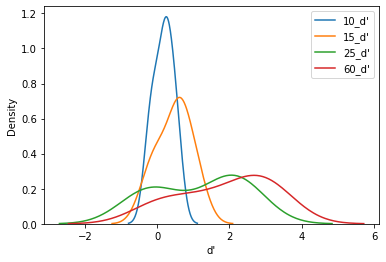

In [17]:
%%capture --no-display

for x in ['10_d\'', '15_d\'', '25_d\'', '60_d\'']:
    sns.distplot(results[x], hist=False)
plt.legend(['10_d\'', '15_d\'', '25_d\'', '60_d\''])
plt.xlabel('d\'')
plt.show()

**Plot $c$**

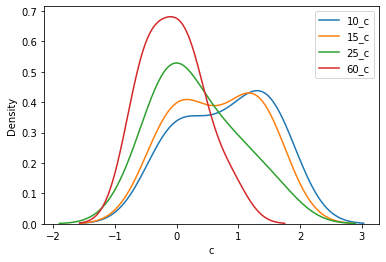

In [24]:
%%capture --no-display

for x in ['10_c', '15_c', '25_c', '60_c']:
    sns.distplot(results[x], hist=False)
plt.legend(['10_c', '15_c', '25_c', '60_c'])
plt.xlabel('c')
plt.show()

**Shapiro-Wilks Test for $d'$**

In [18]:
results.filter(regex=('_d')).apply(stats.shapiro).rename(index={
    0: 'statistics',
    1: 'pvalue'
})

,10_d',15_d',25_d',60_d'
statistics,0.968668,0.956507,0.828829,0.892160
pvalue,0.883103,0.761149,0.043324,0.209966


**Shapiro-Wilks Test for $c$**

In [25]:
results.filter(regex=('_c')).apply(stats.shapiro).rename(index={
    0: 'statistics',
    1: 'pvalue'
})

,10_c,15_c,25_c,60_c
statistics,0.880680,0.901517,0.944075,0.955498
pvalue,0.159627,0.260922,0.625388,0.750228


We reject the null hypothesis that the data from `25_d'` are normally distributed and we can tell that the data from `60_d` are also not well normally distributed. We can run a Mann-Whitney U Test on these comparisons. For $c$, the data from all conditions are normally distributed.

In [19]:
pg.mwu(x=results['10_d\''], y=results['60_d\''])

,U-val,tail,p-val,RBC,CLES
MWU,12.0,two-sided,0.013419,0.703704,0.148148


In [20]:
pg.mwu(x=results['15_d\''], y=results['25_d\''])

,U-val,tail,p-val,RBC,CLES
MWU,29.5,two-sided,0.353588,0.271605,0.364198


We can tell that our first comparison still yields significant results while the second one, comparing `15_d'` and `25_d'`, is no longer significant.

<div class="alert alert-info" role="alert">
  <strong>Question 9</strong> <br>
  OK great job!  You have your data, you have your t-test, you have everything you need to answer the following questions: 1. Is performance higher in the low number of dots or high number of dots condition?  How do you know? 2. How would you report the statistical evidence in favor of your conclusion in a paper? 3. Is the criterion different between the conditions?  How do you know? 4. Overall was performance high or low in this task?
</div>

1. The performance becomes better as the stimulus has more dots, which can be inferred from the increasing $d'$.
2. We conducted two Mann-Whitney U Tests to compare the standardized differences between the means of performances in different stimulus conditions, and we found that subjects perform significantly better in 60-dot condition than in 10-dot ($U=12, p<0.05$). Thus, we reject the null hypothesis that the participants perform the same across conditions. However, we failed to report significance when comparing 15-dot with 25-dot conditions ($U=29.5, p>0.05$).
3. The criterion IS changing between the conditions, as we rejected the null in t-tests for both comparisons.
4. People performed fine in 25-dot and 60-dot conditions and worse in 10-dot and 15-dot conditions.

<div class="alert alert-info" role="alert">
  <strong>Question 10</strong> <br>
  The final question asks you to consider limitations to this experiment design.  What other analyses might be interesting to perform on this data?  If you could change the experiment is there another type of question you would ask?
</div>

I would add more stimulus conditions for deriving the psychometric curve of this task. I would also investigate the performance change and criterion shift as a function of stimulus conditions instead of just getting the significance.